visualize/load data format:

Step 1: Define Target and Format Dataset
Structure data with rows representing each hour.

Each row should include:

timestamp, hour, day_of_week, is_holiday, weather, wave_quality, temperature, past_crowdedness, etc.

Target: crowdedness_percent (0–100%)

| timestamp           | hour | day\_of\_week | is\_holiday | weather | wave\_quality | temp | crowdedness |
| ------------------- | ---- | ------------- | ----------- | ------- | ------------- | ---- | ----------- |
| 2024-03-01 08:00:00 | 8    | Friday        | 0           | Cloudy  | Fair          | 65   | 32          |
| 2024-03-01 09:00:00 | 9    | Friday        | 0           | Cloudy  | Fair          | 66   | 39          |
| ...                 | ...  | ...           | ...         | ...     | ...           | ...  | ...         |

In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Data/dummy_data.csv", parse_dates=['timestamp'])

# Preview the first 5 rows
df.head()


,timestamp,hour,day_of_week,is_holiday,weather,wave_quality,temperature,crowdedness
0,2024-01-01 00:00:00,0,Monday,1,Cloudy,Excellent,67.4,47
1,2024-01-01 01:00:00,1,Monday,1,Cloudy,Excellent,65.0,42
2,2024-01-01 02:00:00,2,Monday,1,Foggy,Excellent,48.9,35
3,2024-01-01 03:00:00,3,Monday,1,Sunny,Excellent,44.5,50
4,2024-01-01 04:00:00,4,Monday,1,Foggy,Excellent,75.3,27


Step 2: Feature Engineering
Convert time and categorical data into usable model features:

Encode hour and day_of_week cyclically

One-hot encode categorical variables (weather, wave quality)

Create lag features: crowdedness_prev_day_same_hour, prev_week_same_hour, etc.

🔄 Why Use Sin/Cos for Time?
Take the hour feature as an example:

Hour 23 (11 PM) is close in time to hour 0 (midnight), but numerically, 23 and 0 are far apart.

A machine learning model won’t know that hour 23 and hour 0 are just 1 hour apart unless we encode this cyclic behavior.

🧠 What Happens Without Sin/Cos?
If you just give the model hour = 0 to hour = 23 as a raw integer:

It may learn incorrect patterns like "higher hour = more crowded."

It will think that hour 23 is far from hour 0, even though they’re adjacent.

In [5]:
import numpy as np

# ---- 1. Cyclical Encoding for Time Features ----
# Encode hour of day (0–23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Encode day of week (0=Monday, 6=Sunday)
df['day_of_week_num'] = pd.to_datetime(df['timestamp']).dt.weekday
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week_num'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week_num'] / 7)

# ---- 2. One-Hot Encoding for Categorical Variables ----
df = pd.get_dummies(df, columns=['weather', 'wave_quality'], drop_first=True)

# ---- 3. Lag and Rolling Features ----
# Sort by time to ensure correct lag calculation
df = df.sort_values('timestamp')

# Create lag features (1 day ago, 7 days ago)
df['lag_1d'] = df['crowdedness'].shift(24)
df['lag_7d'] = df['crowdedness'].shift(24 * 7)

# Create rolling average features (past 3 days and 7 days)
df['rolling_3d'] = df['crowdedness'].shift(1).rolling(window=24*3).mean()
df['rolling_7d'] = df['crowdedness'].shift(1).rolling(window=24*7).mean()

# ---- 4. Drop rows with NaNs caused by shifting/rolling ----
df = df.dropna().reset_index(drop=True)

# ---- (Optional) Preview the processed dataset ----
df.head()


,timestamp,hour,day_of_week,is_holiday,temperature,crowdedness,hour_sin,hour_cos,day_of_week_num,dow_sin,...,weather_Foggy,weather_Rainy,weather_Sunny,wave_quality_Fair,wave_quality_Good,wave_quality_Poor,lag_1d,lag_7d,rolling_3d,rolling_7d
0,2024-01-08 00:00:00,0,Monday,0,51.4,54,0.000000,1.000000,0,0.0,...,False,False,True,False,False,False,41.0,47.0,49.930556,50.636905
1,2024-01-08 01:00:00,1,Monday,0,63.3,40,0.258819,0.965926,0,0.0,...,True,False,False,False,True,False,18.0,42.0,50.152778,50.678571
2,2024-01-08 02:00:00,2,Monday,0,64.7,39,0.500000,0.866025,0,0.0,...,False,False,False,False,False,False,35.0,35.0,50.111111,50.666667
3,2024-01-08 03:00:00,3,Monday,0,51.5,38,0.707107,0.707107,0,0.0,...,False,False,False,False,False,False,39.0,50.0,50.263889,50.690476
4,2024-01-08 04:00:00,4,Monday,0,72.0,38,0.866025,0.500000,0,0.0,...,False,False,False,False,True,False,22.0,27.0,50.472222,50.619048


Step 3: Split Data
Train/Test split:

Train on past data (e.g., Jan–Apr), test on recent unseen days (e.g., May).

Make sure not to leak future info into training.

In [7]:
from sklearn.model_selection import train_test_split

# Define the target variable and input features
target = 'crowdedness'

# Exclude non-numeric or irrelevant columns
features = df.columns.difference(['timestamp', 'day_of_week', 'crowdedness'])

X = df[features]
y = df[target]

# Time-aware split: use first 80% for training, last 20% for testing
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Confirm shapes
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (1594, 18) (1594,)
Test set: (399, 18) (399,)


Step 4: Choose and Train Model
Use XGBoostRegressor or RandomForestRegressor for tabular data

Inputs: All engineered features

Output: Crowdedness percentage for each hour

MAE: 4.28
RMSE: 5.31


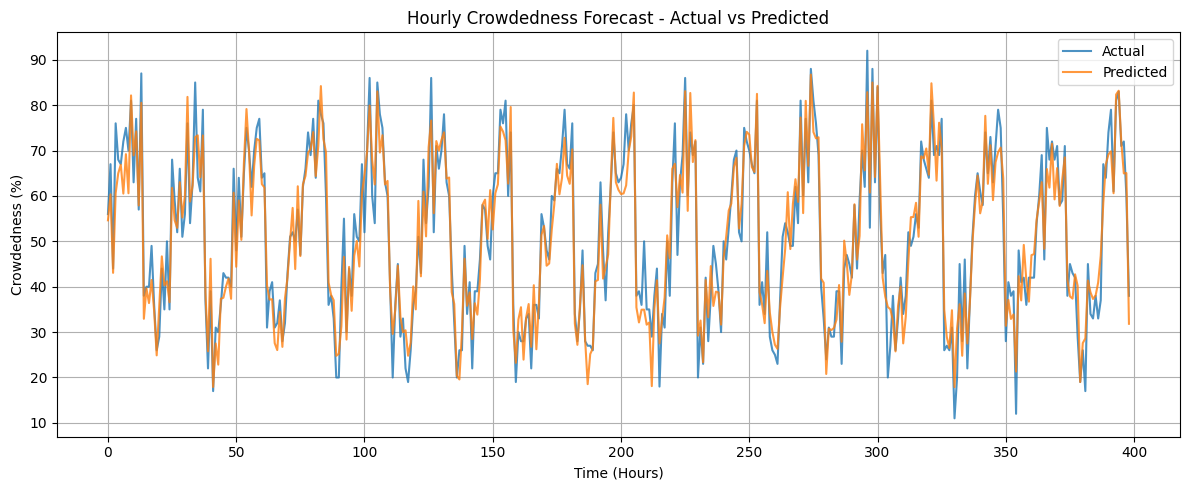

In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Train the model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Hourly Crowdedness Forecast - Actual vs Predicted')
plt.xlabel('Time (Hours)')
plt.ylabel('Crowdedness (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Interpretation of Results
MAE and RMSE Values (as printed):

MAE: average prediction error in % crowdedness (e.g., ±7% off on average).

RMSE: penalizes larger errors more than MAE — useful for catching spikes or outliers.

Prediction Curve:

Model captures overall crowd flow patterns (rises and falls).

Some lag on sharp changes — common unless you add more granular temporal dependencies or use sequential models like LSTMs.

## Step 5 – Forecast Tomorrow’s Crowdedness

Now that the model is trained, we use it to forecast **hourly crowdedness for a future day (e.g., tomorrow)** based on the latest weather, wave, and time features.

This step assumes you have access to forecasted conditions (weather, wave quality, etc.) for the next day.

For this example, we simulate tomorrow’s inputs based on typical values and generate:
- A **24-hour forecast** of crowdedness
- A summary including:
  - Predicted **peak time**
  - **Least crowded** time
  - **Average crowdedness**


C:\Users\chris\AppData\Local\Temp\ipykernel_21212\1901079777.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_hours = pd.date_range(start=tomorrow.replace(hour=0, minute=0, second=0), periods=24, freq='H')


Peak crowdedness: 80.80% at 08:00 PM
Least crowded: 44.88% at 05:00 AM
Average crowdedness: 62.63%


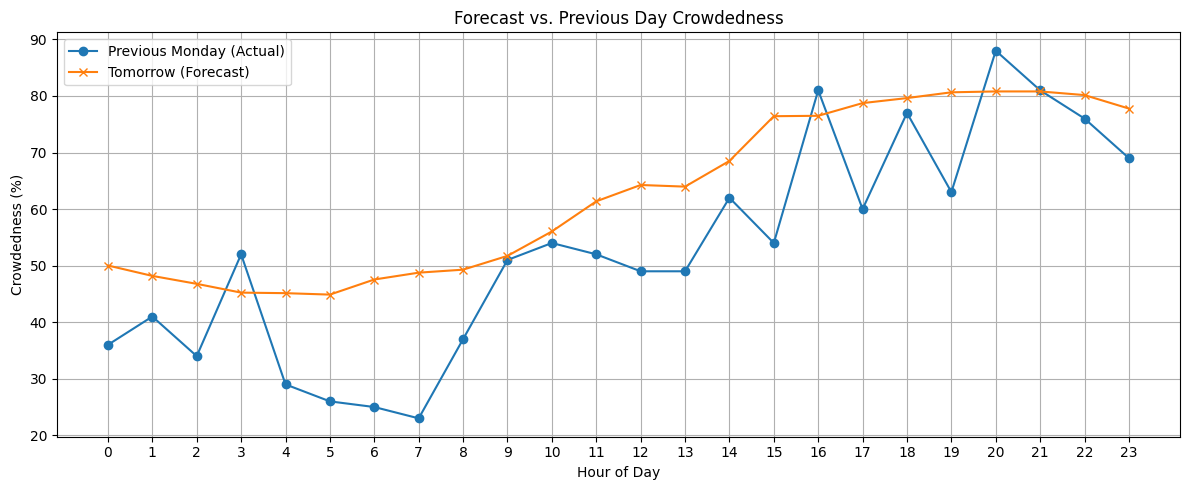

In [10]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# STEP 1: Forecast Setup (Same as before)
tomorrow = df['timestamp'].max() + timedelta(days=1)
forecast_hours = pd.date_range(start=tomorrow.replace(hour=0, minute=0, second=0), periods=24, freq='H')

simulated_weather = 'Sunny'
simulated_wave_quality = 'Good'
simulated_temperature = 68

forecast_df = pd.DataFrame({
    'timestamp': forecast_hours,
    'hour': forecast_hours.hour,
    'is_holiday': 0,
    'temperature': simulated_temperature
})
forecast_df['day_of_week_num'] = forecast_df['timestamp'].dt.weekday
forecast_df['hour_sin'] = np.sin(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['hour_cos'] = np.cos(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['dow_sin'] = np.sin(2 * np.pi * forecast_df['day_of_week_num'] / 7)
forecast_df['dow_cos'] = np.cos(2 * np.pi * forecast_df['day_of_week_num'] / 7)

# One-hot encoding
for col in ['weather_Cloudy', 'weather_Foggy', 'weather_Rainy', 'weather_Sunny']:
    forecast_df[col] = 1 if col == f'weather_{simulated_weather}' else 0
for col in ['wave_quality_Excellent', 'wave_quality_Fair', 'wave_quality_Good', 'wave_quality_Poor']:
    forecast_df[col] = 1 if col == f'wave_quality_{simulated_wave_quality}' else 0

# Use trailing average values for lag features
forecast_df['lag_1d'] = df['crowdedness'].rolling(24).mean().iloc[-1]
forecast_df['lag_7d'] = df['crowdedness'].rolling(24*7).mean().iloc[-1]
forecast_df['rolling_3d'] = df['crowdedness'].rolling(24*3).mean().iloc[-1]
forecast_df['rolling_7d'] = df['crowdedness'].rolling(24*7).mean().iloc[-1]

# Predict
forecast_X = forecast_df[X_train.columns]
forecast_df['predicted_crowdedness'] = model.predict(forecast_X)

# STEP 2: Retrieve Previous Same-Weekday Data
target_weekday = forecast_df['timestamp'].dt.weekday[0]
past_same_day = df[df['day_of_week_num'] == target_weekday]
previous_date = past_same_day[past_same_day['timestamp'] < forecast_df['timestamp'][0]].timestamp.max().date()
previous_df = df[df['timestamp'].dt.date == previous_date]

# STEP 3: Summary Output
peak_hour = forecast_df.loc[forecast_df['predicted_crowdedness'].idxmax()]
low_hour = forecast_df.loc[forecast_df['predicted_crowdedness'].idxmin()]
avg_crowdedness = forecast_df['predicted_crowdedness'].mean()

print(f"Peak crowdedness: {peak_hour['predicted_crowdedness']:.2f}% at {peak_hour['timestamp'].strftime('%I:%M %p')}")
print(f"Least crowded: {low_hour['predicted_crowdedness']:.2f}% at {low_hour['timestamp'].strftime('%I:%M %p')}")
print(f"Average crowdedness: {avg_crowdedness:.2f}%")

# STEP 4: Visualization
plt.figure(figsize=(12, 5))
plt.plot(previous_df['timestamp'].dt.hour, previous_df['crowdedness'], label=f'Previous {previous_df["timestamp"].dt.day_name().iloc[0]} (Actual)', marker='o')
plt.plot(forecast_df['timestamp'].dt.hour, forecast_df['predicted_crowdedness'], label="Tomorrow (Forecast)", marker='x')
plt.title("Forecast vs. Previous Day Crowdedness")
plt.xlabel("Hour of Day")
plt.ylabel("Crowdedness (%)")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()
